In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import pandas as pd

# TEOTIL3 Trondheimsfjorden

# Part 6c: Generate model input files for combined wastewater scenario

Assume `AV1` plus `AV3` i.e all wastewater treatment plants serving more than 10k people are upgraded to `Biologisk/kjemisk med N fjerning` and all spredt sites are connected to a modern `Minirenseanlegg biologisk/kjemisk`.

In [2]:
nve_year = 2024
st_yr, end_yr = 2013, 2023
scen_fold = r"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/teotil3_input_files"
scen_name = "AV4"

# Scenarios to combine
large_scen = "AV1"
spredt_scen = "AV3"

# Whether to delete the scenario folder first if it already exists
delete_existing = True

In [3]:
# Create scenario folder structure
new_scen_fold = f"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/teotil3_input_files/{scen_name}"
if os.path.exists(new_scen_fold) and delete_existing:
    shutil.rmtree(new_scen_fold)
os.makedirs(new_scen_fold)

# Generate modified data for scenario
print("Generating scenario data")
years = range(st_yr, end_yr + 1)
for year in years:
    print("    ", year)

    # Read original TEOTIL3 input files
    base_csv = os.path.join(
        scen_fold,
        "Baseline",
        f"trondheimsfjorden_input_data_scen-baseline_nve{nve_year}_{year}.csv",
    )
    df = pd.read_csv(base_csv)

    # Read large wastewater scenario
    lrg_csv = os.path.join(
        scen_fold,
        large_scen,
        f"trondheimsfjorden_input_data_scen-{large_scen.lower()}_nve{nve_year}_{year}.csv",
    )
    lrg_df = pd.read_csv(lrg_csv)

    # Read spredt scenario
    spr_csv = os.path.join(
        scen_fold,
        spredt_scen,
        f"trondheimsfjorden_input_data_scen-{spredt_scen.lower()}_nve{nve_year}_{year}.csv",
    )
    spr_df = pd.read_csv(spr_csv)

    # Update baseline with large-wastewater scenario
    lrg_cols = [col for col in lrg_df.columns if col.startswith("large-wastewater_")]
    lrg_df = lrg_df[["regine"] + lrg_cols]
    df.drop(columns=lrg_cols, inplace=True)
    df = pd.merge(df, lrg_df, how="left", on="regine")
    for col in lrg_cols:
        df[col] = df[col].fillna(0)

    # Update baseline with spredt scenario
    spr_cols = [col for col in spr_df.columns if col.startswith("spredt_")]
    spr_df = spr_df[["regine"] + spr_cols]
    df.drop(columns=spr_cols, inplace=True)
    df = pd.merge(df, spr_df, how="left", on="regine")
    for col in spr_cols:
        df[col] = df[col].fillna(0)

    # Save modified model input file
    scen_csv = os.path.join(
        new_scen_fold,
        f"trondheimsfjorden_input_data_scen-{scen_name.lower()}_nve{nve_year}_{year}.csv",
    )
    df.to_csv(scen_csv, index=False)

Generating scenario data
     2013
     2014
     2015
     2016
     2017
     2018
     2019
     2020
     2021
     2022
     2023


## 3. Compare input files

In [4]:
for year in years:
    orig_csv = os.path.join(
        scen_fold,
        "Baseline",
        f"trondheimsfjorden_input_data_scen-baseline_nve{nve_year}_{year}.csv",
    )
    orig_df = pd.read_csv(orig_csv)

    scen_csv = os.path.join(
        scen_fold,
        scen_name,
        f"trondheimsfjorden_input_data_scen-{scen_name.lower()}_nve{nve_year}_{year}.csv",
    )
    scen_df = pd.read_csv(scen_csv)

    assert scen_df.shape == orig_df.shape

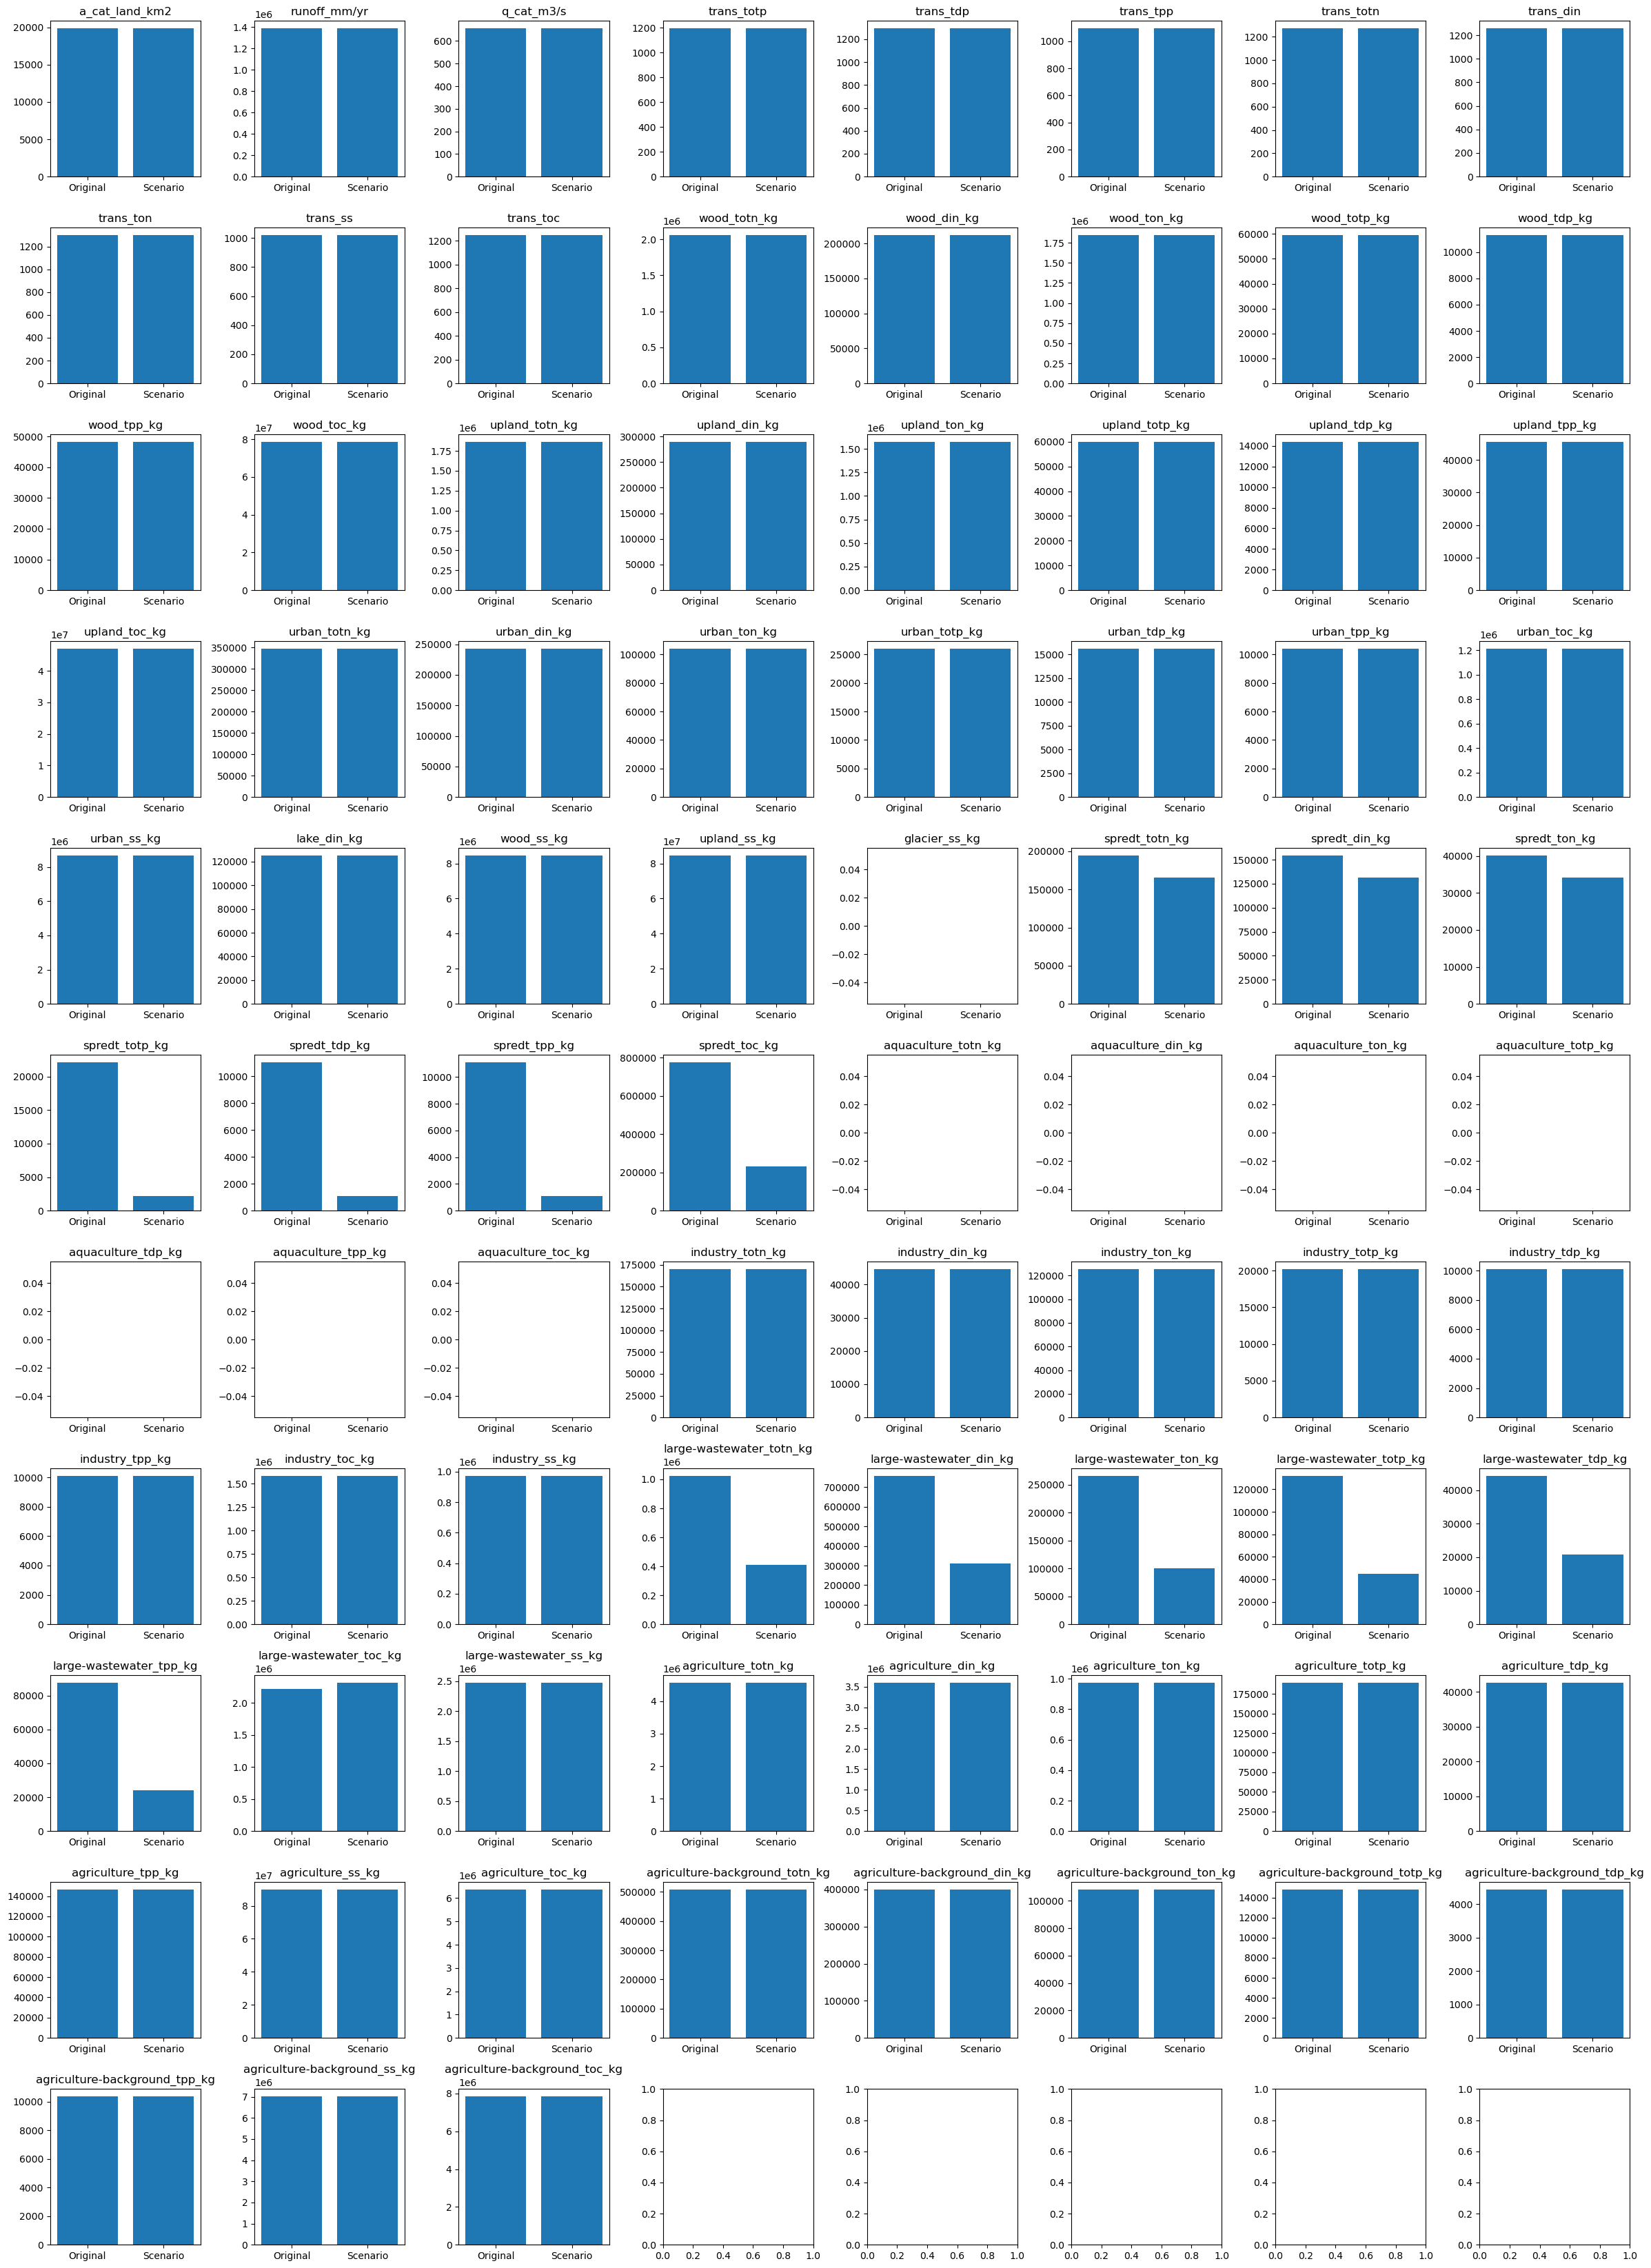

In [5]:
# Plot national total for each model input by source for the last year
# Just to check that only large wastewater has changed.
n_subplots = len(orig_df.select_dtypes(include="number").columns)
n_cols = 8
fig, axes = plt.subplots(
    int(n_subplots / n_cols) + 1,
    n_cols,
    figsize=(n_cols * 3, (int(n_subplots / n_cols) + 1) * 3),
)
axes = axes.flatten()
for i, col in enumerate(orig_df.select_dtypes(include="number").columns):
    axes[i].bar(["Original", "Scenario"], [orig_df.sum()[col], scen_df.sum()[col]])
    axes[i].set_title(col)

plt.tight_layout()